In [39]:
from google.colab import drive
drive.mount('/content/gdrive')
!cp /content/gdrive/My\ Drive/SelfDrive/hw2 -r ./
%cd hw2

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/hw2/hw2/hw2


# Домашнее задание

ML разработчикам необходимо не только уметь обучать нейронные сети и генерировать новые идеи, но еще и уметь встраивать наработки в pipeline. В этом домашнем задании нам предстоит сделать из frustum детектора production ready (ну почти) решение, которое может работать на сырых данных.

К сожалению, frustum-pointnet работает независимо для каждой 2D детекции. В этом домашнем задании вам предстоит написать обертку над frustum-pointnet, которая будет работать над целыми облаками. Вам также нужно будет воспользоваться 2D детектором, чтобы находить коробки на изображении.

Во второй части задания вам нужно будет написать оценку качества работы вашего алгоритма, которая становится чуть сложнее, когда на сцене могут находится много объектов.

## Часть 1

Ниже написан класс, который вам нужно реализовать. Чтобы воспользоваться предобученной сетью, позаимствуйте код из
https://github.com/charlesq34/frustum-pointnets/blob/master/train/test.py

Предобученные модели лежат здесь: https://shapenet.cs.stanford.edu/media/frustum_pointnets_snapshots.zip

В частности, вам нужно модифицировать функцию `get_session_and_ops` - функция должна уметь работать без глобальных флагов. После этого посмотрите, как эта функция используется.
Выход сети преобразуется в понятный формат в функции `write_detection_results`.

In [ ]:
! pip install "tensorflow==1.14"

In [ ]:
!wget https://shapenet.cs.stanford.edu/media/frustum_pointnets_snapshots.zip --no-check-certificate
!unzip frustum_pointnets_snapshots.zip

In [41]:
import sys
sys.path.append('frustum-pointnets/kitti')
sys.path.append('frustum-pointnets/models')
sys.path.append('frustum-pointnets/train')

In [42]:
import os
import sys
import importlib
import numpy as np
import tensorflow as tf

def get_session_and_ops(model, model_path, batch_size, num_point):
    ''' Define model graph, load model parameters,
    create session and return session handle and tensors
    '''
    with tf.Graph().as_default():
        with tf.device('/gpu:0'):
            pointclouds_pl, one_hot_vec_pl, labels_pl, centers_pl, \
            heading_class_label_pl, heading_residual_label_pl, \
            size_class_label_pl, size_residual_label_pl = \
                model.placeholder_inputs(batch_size, num_point)
            is_training_pl = tf.placeholder(tf.bool, shape=())
            end_points = model.get_model(pointclouds_pl, one_hot_vec_pl,
                is_training_pl)
            loss = model.get_loss(labels_pl, centers_pl,
                heading_class_label_pl, heading_residual_label_pl,
                size_class_label_pl, size_residual_label_pl, end_points)
            saver = tf.train.Saver()

        # Create a session
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        sess = tf.Session(config=config)

        # Restore variables from disk.
        saver.restore(sess, model_path)
        ops = {'pointclouds_pl': pointclouds_pl,
               'one_hot_vec_pl': one_hot_vec_pl,
               'labels_pl': labels_pl,
               'centers_pl': centers_pl,
               'heading_class_label_pl': heading_class_label_pl,
               'heading_residual_label_pl': heading_residual_label_pl,
               'size_class_label_pl': size_class_label_pl,
               'size_residual_label_pl': size_residual_label_pl,
               'is_training_pl': is_training_pl,
               'logits': end_points['mask_logits'],
               'center': end_points['center'],
               'end_points': end_points,
               'loss': loss}
        return sess, ops

In [43]:
import frustum_pointnets_v1

BATCH_SIZE = 1
NUM_POINT = 1024

frustum_pointnet = get_session_and_ops(frustum_pointnets_v1, 'frustum_pointnets_snapshots/log_v1/model.ckpt', BATCH_SIZE, NUM_POINT)

In [110]:
NUM_CLASSES = 2
NUM_HEADING_BIN = 12
NUM_SIZE_CLUSTER = 8

In [123]:
def inference(sess, ops, pc, one_hot_vec, batch_size):
    ''' Run inference for frustum pointnets in batch mode '''
    assert pc.shape[0]%batch_size == 0
    num_batches = pc.shape[0]/batch_size
    logits = np.zeros((pc.shape[0], pc.shape[1], NUM_CLASSES))
    centers = np.zeros((pc.shape[0], 3))
    heading_logits = np.zeros((pc.shape[0], NUM_HEADING_BIN))
    heading_residuals = np.zeros((pc.shape[0], NUM_HEADING_BIN))
    size_logits = np.zeros((pc.shape[0], NUM_SIZE_CLUSTER))
    size_residuals = np.zeros((pc.shape[0], NUM_SIZE_CLUSTER, 3))
    scores = np.zeros((pc.shape[0],)) # 3D box score 
   
    ep = ops['end_points'] 
    for i in range(num_batches):
        feed_dict = {\
            ops['pointclouds_pl']: pc[i*batch_size:(i+1)*batch_size,...],
            ops['one_hot_vec_pl']: one_hot_vec[i*batch_size:(i+1)*batch_size,:],
            ops['is_training_pl']: False}

        batch_logits, batch_centers, \
        batch_heading_scores, batch_heading_residuals, \
        batch_size_scores, batch_size_residuals = \
            sess.run([ops['logits'], ops['center'],
                ep['heading_scores'], ep['heading_residuals'],
                ep['size_scores'], ep['size_residuals']],
                feed_dict=feed_dict)

        logits[i*batch_size:(i+1)*batch_size,...] = batch_logits
        centers[i*batch_size:(i+1)*batch_size,...] = batch_centers
        heading_logits[i*batch_size:(i+1)*batch_size,...] = batch_heading_scores
        heading_residuals[i*batch_size:(i+1)*batch_size,...] = batch_heading_residuals
        size_logits[i*batch_size:(i+1)*batch_size,...] = batch_size_scores
        size_residuals[i*batch_size:(i+1)*batch_size,...] = batch_size_residuals

        '''# Compute scores
        batch_seg_prob = softmax(batch_logits)[:,:,1] # BxN
        batch_seg_mask = np.argmax(batch_logits, 2) # BxN
        mask_mean_prob = np.sum(batch_seg_prob * batch_seg_mask, 1) # B,
        mask_mean_prob = mask_mean_prob / np.sum(batch_seg_mask,1) # B,
        heading_prob = np.max(softmax(batch_heading_scores),1) # B
        size_prob = np.max(softmax(batch_size_scores),1) # B,
        batch_scores = np.log(mask_mean_prob) + np.log(heading_prob) + np.log(size_prob)
        scores[i*batch_size:(i+1)*batch_size] = batch_scores 
        # Finished computing scores'''

    heading_cls = np.argmax(heading_logits, 1) # B
    size_cls = np.argmax(size_logits, 1) # B
    heading_res = np.array([heading_residuals[i,heading_cls[i]] \
        for i in range(pc.shape[0])])
    size_res = np.vstack([size_residuals[i,size_cls[i],:] \
        for i in range(pc.shape[0])])

    return np.argmax(logits, 2), centers, heading_cls, heading_res, \
        size_cls, size_res#, scores

In [131]:
from collections import namedtuple
import kitti_object
import provider

Detection = namedtuple('Detection', ['xyz', 'angle', 'lwh', 'confidence'])
Scene = namedtuple('Scene', ['detections'])

class PipelineDetector(object):
    def __init__(self, frustum_pointnet, frustum_batch_size, ssd_detector, ssd_threshold):
        self.sess, self.ops = frustum_pointnet
        self.frustum_batch_size = frustum_batch_size
        self.ssd_detector = ssd_detector
        self.ssd_threshold = ssd_threshold
    
    def predict(self, xyz, image, calibration):
        # run 2D detector on the image
        ssd_pred = self.ssd_detector.predict(image)

        # extract bounding boxes with vehicle classes and filter them by ssd_threshold
        n_pred = ssd_pred['num_detections']
        boxes = ssd_pred['detection_boxes'][:n_pred]
        scores = ssd_pred['detection_scores'][:n_pred]
        classes = ssd_pred['detection_classes'][:n_pred]
        mask = (classes == 1) & (scores > self.ssd_threshold)
        boxes, scores, classes = boxes[mask], scores[mask], classes[mask]
        if len(boxes) == 0:
            return Scene([])

        # process lidar point cloud and construct frustum examples
        # kitti/prepare_data.py
        ids = []
        angles = []
        frustums = []
        _, pts_2d, fov_inds = kitti_object.get_lidar_in_image_fov(xyz[:, :3].copy(),
                                                                 calibration, 0, 0,
                                                                 image.shape[1], image.shape[0],
                                                                 return_more=True)
        for i in range(len(boxes)):
            ymin, xmin, ymax, xmax = boxes[i]
            ymin, ymax = ymin * image.shape[0], ymax * image.shape[0]
            xmin, xmax = xmin * image.shape[1], xmax * image.shape[1]
            mask = (pts_2d[:,0]<xmax) & (pts_2d[:,0]>=xmin) & (pts_2d[:,1]<ymax) & (pts_2d[:,1]>=ymin)
            xyz_new = xyz[fov_inds & mask, :]
            if len(xyz_new) == 0:
                continue
            ids.append(i)
            uvdepth = np.array([[(xmin + xmax) / 2., (ymin + ymax) / 2., 20]])
            rect = calibration.project_image_to_rect(uvdepth)
            angle = -1 * np.arctan2(rect[0, 2], rect[0, 0]) + np.pi / 2
            choice = np.random.choice(xyz_new.shape[0], NUM_POINT)
            frustum = xyz_new[np.random.choice(xyz_new.shape[0], NUM_POINT)]
            frustum[:, :3] = calibration.project_velo_to_ref(frustum[:, :3]).copy()
            frustum[:, :3] = provider.rotate_pc_along_y(frustum[:, :3], angle).copy()
            frustums.append(frustum)
            angles.append(angle)

        # run frustum inference (use batch to accelerate inference per frame)
        _, centers, heading_cls, heading_res, size_cls, size_res = inference(self.sess, self.ops,
                                                                             np.array(frustums),
                                                                             np.array([[1, 0, 0]] * len(ids)),
                                                                             self.frustum_batch_size)
        results = []
        for i in range(len(centers)):
            c, hcls, hres, scls, sres = centers[i], heading_cls[i], heading_res[i], size_cls[i], size_res[i]
            angle = angles[i]
            score = scores[ids[i]]
            h, w, l, tx, ty, tz, ry = provider.from_prediction_to_label_format(c, hcls, hres, scls, sres, angle)
            res = Detection(xyz=np.array([tx, ty, tz]), angle=ry, lwh=np.array([l, w, h]), confidence=score)
            results.append(res)
        return Scene(results)
    

### 2D детектор

В файле ssd.py есть детектор (файл называется ssd, но на самом деле там faster-rcnn), обученный на kitti. У него можно позвать predict на одном изображении. Коробки возвращаются в нормализованных координатах картинки. Класс 1 соответствует машинам, 2 - пешеходам.

In [46]:
from ssd import SSD
import pickle

In [47]:
dirName = 'tmp'
if not os.path.exists(dirName):
    os.mkdir(dirName)
detector = SSD(dirName)

In [132]:
pipeline = PipelineDetector(frustum_pointnet, BATCH_SIZE, detector, 0.9)

## Часть 2

Для оценки качества работы 3D детекторов обычно используется average precision. Как измерить precision и recall детектора?

У каждой коробки детектора есть confidence. После того, как мы зафиксировали порог, у нас остается часть детекций.
Давайте теперь посмотрим на сцену сверху: bird's eye view. Забудем про координату z.

Далее мы можем посчитать IoU между всеми коробками ground truth и нашими детекциями.Давайте решим, что если IoU больше 0.7, то мы будем считать, что мы увидели gt коробку - относим эту детекцию к TP. Если gt не нашла пару - False Negative. Если детекция не нашла пару - False Positive.

Ваша задача написать код подсчета метрики average precision построенного детектора.

# Kitti Dataset
[Kitti dev-kit](https://s3.eu-central-1.amazonaws.com/avg-kitti/devkit_object.zip) : 
там можно найти описание данных и как преобразовывать данные между системами координат.

Homework KITTI dataset :https://www.icloud.com/iclouddrive/0bxlXWgCRTVvsWXmd-kcEqKqA#kitti_hw_dataset

In [49]:
import numpy as np
from matplotlib import pyplot as plt 

In [ ]:
!tar -xzvf  kitti_hw_dataset.tar.gz

In [60]:
xyzi = np.fromfile('training/velodyne/000100.bin', dtype=np.float32).reshape(-1, 4)

In [61]:
xyzi

array([[43.889,  0.084,  1.693,  0.   ],
       [43.201,  0.218,  1.67 ,  0.   ],
       [42.397,  0.347,  1.643,  0.   ],
       ...,
       [ 3.696, -1.398, -1.726,  0.31 ],
       [ 3.717, -1.399, -1.736,  0.35 ],
       [ 3.724, -1.389, -1.737,  0.   ]], dtype=float32)

(-50, 50)

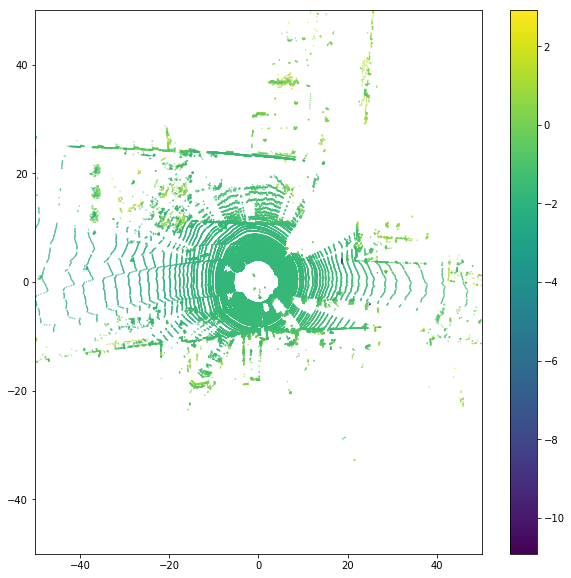

In [62]:
plt.figure(figsize=(10, 10))
plt.scatter(xyzi[:, 0], xyzi[:, 1], c=xyzi[:, 2],  s=0.1)
plt.colorbar()
plt.xlim(-50, 50)
plt.ylim(-50, 50)

In [96]:
IMAGE_ID = 10
data = kitti_object.kitti_object('.')
xyz = data.get_lidar(IMAGE_ID)
image = data.get_image(IMAGE_ID)
calibration = data.get_calibration(IMAGE_ID)
labels = data.get_label_objects(IMAGE_ID)

In [133]:
result = pipeline.predict(xyz, image, calibration)

In [135]:
result.detections

[Detection(xyz=array([ 5.99692594,  1.81830663, 16.50980903]), angle=-1.4078525333225929, lwh=array([3.53880105, 1.56570912, 1.48331034]), confidence=1.0),
 Detection(xyz=array([-2.29566852,  1.76803272, 11.87434105]), angle=1.739675294327315, lwh=array([3.97049683, 1.64531527, 1.4620646 ]), confidence=0.9999999),
 Detection(xyz=array([4.46214187, 1.79906232, 5.1289702 ]), angle=-1.4129433796282056, lwh=array([3.91971394, 1.66582766, 1.52967037]), confidence=0.9999999),
 Detection(xyz=array([-0.15872456,  1.77657594, 23.90293105]), angle=1.7531262190540877, lwh=array([3.9504572 , 1.61253755, 1.45772174]), confidence=0.99999976),
 Detection(xyz=array([11.69704875,  1.94351661, 52.37396243]), angle=2.2355727781567367, lwh=array([3.95293679, 1.64190841, 1.61693502]), confidence=0.9999994),
 Detection(xyz=array([ 4.72930183,  1.88441142, 42.77143259]), angle=2.018486854376837, lwh=array([3.52232088, 1.5314549 , 1.5188226 ]), confidence=0.9999949),
 Detection(xyz=array([ 6.98320183,  1.8982

In [174]:
from shapely.geometry import Polygon
from shapely.affinity import rotate

def get_polygon(x, y, l, w, a):
    polygon = Polygon([[-w / 2, -l / 2], [-w / 2, l / 2], [w / 2, l / 2], [w / 2, -l / 2]])
    polygon = rotate(polygon, a, use_radians=True)
    coords = np.array(polygon.exterior.coords)
    coords[:, 0] += x
    coords[:, 1] += y
    return Polygon([coords[0], coords[1], coords[2], coords[3]])

def get_gt_boxes(labels):
    boxes = []
    for label in labels:
        if label.type == "Car":
            (x, y, _), l, w, a = label.t, label.l, label.w, label.ry
            boxes.append(get_polygon(x, y, l, w, a))
    return np.array(boxes)

def get_pred_boxes(scene):
    boxes = []
    for detection in scene.detections:    
        (x, y, _), (l, w, _), a = detection.xyz, detection.lwh, detection.angle
        boxes.append(get_polygon(x, y, l, w, a))
    return np.array(boxes)

In [213]:
MIN_IOU = 0.7
n = 1000
scores = np.array([])
tps = np.array([])
n_trues = 0

for i in range(n):
    xyz = data.get_lidar(i)
    image = data.get_image(i)
    calibration = data.get_calibration(i)
    labels = data.get_label_objects(i)
    
    scene = pipeline.predict(xyz, image, calibration)
    if len(scene.detections) == 0:
        continue
    trues = get_gt_boxes(labels)
    n_trues += len(trues)
    preds = get_pred_boxes(scene)
    score = [d.confidence for d in scene.detections]
    if len(trues) == 0:
        continue
    iou = np.array([[p1.intersection(p2).area / p1.union(p2).area for p2 in trues] for p1 in preds])
    ids = np.argmax(iou, axis=1)
    iou = np.array([iou[j][id] for j, id in enumerate(ids)])
    tp = iou > MIN_IOU

    tps = np.hstack((tps, tp))
    scores = np.hstack((scores, score))

In [214]:
from sklearn.metrics import average_precision_score
average_precision_score(tps, scores)

0.8157115397496885